Load the data (images shape: 7000 x 28 x 28, labels shape: 7000)


In [4]:
!pip install tensorflow
!pip install keras

In [5]:
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model, Input
from keras import Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
import numpy as np
import pickle as pk
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras import models, layers



In [6]:
with open('input_data.pkl', 'rb') as f:
    dd = pk.load(f)

data = dd['data']
labels = dd['labels']

X_train, X_test, y_train, y_test = train_test_split(
    data, labels,
    test_size=0.2,
    random_state=42
)

print(X_train.shape, y_train.shape)


(5600, 28, 28) (5600,)


data is (7000, 28, 28), label is a 1D vector with 7000 values

CHANGE: Instead of no preprocessing, a minMaxScaler would be better on the pixels (between 0 and 1)
but could simply divide by 255 every value, same effect!

np.max(X_train[0]):1.0


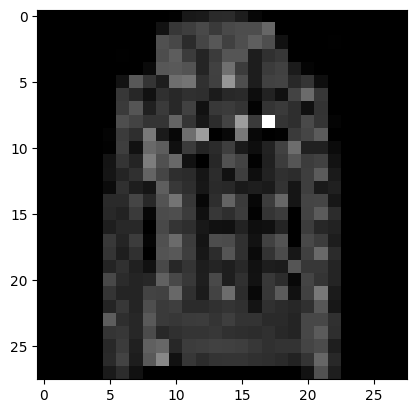

In [7]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

plt.imshow(X_train[0].squeeze(), cmap='gray')
print(f"np.max(X_train[0]):{np.max(X_train[0])}")

reshaping such that it looks like (height, weight, 1)
float32 better to work with

In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print(f"X_train.shape:{X_train.shape}")
print(f"X_test.shape:{X_test.shape}")
print(f"np.max(X_train):{np.max(X_train)}, np.min(X_train):{np.min(X_train)}")

X_train.shape:(5600, 28, 28, 1)
X_test.shape:(1400, 28, 28, 1)
np.max(X_train):1.0, np.min(X_train):0.0


In [9]:
n_classes = len(np.unique(y_train))
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(f"n_classes:{n_classes}, input_shape:{input_shape}")

n_classes:10, input_shape:(28, 28, 1)


CHANGE: instead of searching from 4 to 10 (kernel size), i chose to tighten the bound to 5, 7, 9, which would save me a lot of time. not that big of a change, just faster.

ANOTHER CHANGE: instead of using grid search, i decided to use a separate model to find the optimal kernel size, because I could not find a way to use the convoluted image instead of the output of the MLP in a grid search. But this way I can 1)train the CNN with the optimal kernel size + 2)feed the vae the convoluted image.

In [10]:
kernel_sizes = [5, 7, 9]  # Test these kernel sizes
best_accuracy = 0
best_model = None
best_kernel = None

for k_size in kernel_sizes:
    print(f"Testing kernel size: {k_size}x{k_size}")

    model = Sequential([
        Conv2D(64, kernel_size=(k_size, k_size),
               input_shape=input_shape,
               padding='same',
               activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        layers.Dense(128, activation="relu"),  # expand
        layers.Dense(256, activation="relu"),  # expand
        layers.Dense(128, activation="relu"),  # contract
        layers.Dense(64, activation="relu"),   # contract
        layers.Dense(10, activation="softmax") # output layer
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                       batch_size=64,
                       epochs=10,
                       verbose=1,
                       validation_data=(X_test, y_test))

    val_acc = max(history.history['val_accuracy'])
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_kernel = k_size
        best_model = model
        print(f"New best kernel: {k_size}x{k_size} with accuracy: {val_acc:.4f}")


print(f"\nSaved best model with kernel size {best_kernel}x{best_kernel} ")

Testing kernel size: 5x5
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.4862 - loss: 1.3743 - val_accuracy: 0.7657 - val_loss: 0.6245
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7946 - loss: 0.5611 - val_accuracy: 0.8057 - val_loss: 0.5082
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8360 - loss: 0.4554 - val_accuracy: 0.8179 - val_loss: 0.4581
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8620 - loss: 0.3811 - val_accuracy: 0.8629 - val_loss: 0.4031
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8862 - loss: 0.3244 - val_accuracy: 0.8300 - val_loss: 0.4305
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9020 - loss: 0.2792 - val_accuracy: 0.8400 - val_loss: 0.4465
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9048 - loss: 0.2616 - val_accuracy: 0.8629 - val_loss: 0.3784
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9274 - loss: 0.2101 - val_accuracy: 0.8564 - val_loss: 0.4289

5x5 turned out to be the best! so will use 5X5 kernel (1 convolution).

As I wrote, using adam for optimization, categorical cross-entropy, and accuracy

In [11]:
conv_model = models.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
])

the input is the output of the convolution.

Using the same architecture as when I tested the kernel sizes.

In [12]:
mlp_model = Sequential([
    layers.Input(shape=(conv_model.output_shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [13]:
inputs = Input(shape=(28, 28, 1))
x = conv_model(inputs)
outputs = mlp_model(x)
model = Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test)
)


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5098 - loss: 1.3857 - val_accuracy: 0.7457 - val_loss: 0.6977
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7655 - loss: 0.6158 - val_accuracy: 0.7964 - val_loss: 0.5552
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8237 - loss: 0.4764 - val_accuracy: 0.8193 - val_loss: 0.4945
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8598 - loss: 0.3939 - val_accuracy: 0.8300 - val_loss: 0.4570
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8770 - loss: 0.3506 - val_accuracy: 0.8514 - val_loss: 0.4227
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8886 - loss: 0.3072 - val_accuracy: 0.8493 - val_loss: 0.4231
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8948 - loss: 0.2922 - val_accuracy: 0.8500 - val_loss: 0.4322
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9087 - loss: 0.2474 - val_accuracy: 0.8550 - val_loss

CHANGE: an error I have made in my exam, is to incorrectly answer the loss and metric of the VAE (on metric i wrote accuracy, on loss I wrote the standard formula 1/n sum (d-z)). And so for the VAE to correctly work I shall use KL Divergence as the loss function, and Mean Squared Error as the metric.

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

latent_dim = 2
flat_input_dim = 4608  # output shape from convolution

encoder_inputs = Input(shape=(flat_input_dim,))
x = layers.Dense(256, activation='relu')(encoder_inputs)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

latent_inputs = Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(256, activation='relu')(x)
decoder_outputs = layers.Dense(flat_input_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, decoder_outputs, name='decoder')

# VAE
outputs = decoder(z)
vae = Model(encoder_inputs, outputs, name='vae')

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.abs(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "mae": reconstruction_loss,
            "kl_loss": kl_loss,
        }


vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.summary()

conv_out = conv_model.predict(X_train)
conv_out = conv_out.reshape(conv_out.shape[0], -1)
print(f"conv_out.shape:{conv_out.shape}")
vae.fit(conv_out, conv_out, epochs=10, batch_size=32)


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 2), (None, 2), │     1,213,316 │
│                                 │ (None, 2))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 4608)           │     1,217,664 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,980 (9.27 MB)

 Trainable params: 2,430,980 (9.27 MB)

 Non-trainable params: 0 (0.00 B)

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
conv_out.shape:(5600, 4608)
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kl_loss: 0.0026 - loss: 0.0965 - mae: 0.0939
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 5.3272e-05 - loss: 0.0368 - mae: 0.0367
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 3.3905e-05 - loss: 0.0364 - mae: 0.0364
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 2.7337e-05 - loss: 0.0360 - mae: 0.0359
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - kl_loss: 1.9373e-05 - loss: 0.0355 - mae: 0.0355
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 1.5511e-05 - loss: 0.0353 - mae: 0.0353
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 1.2902e-05 - loss: 0.0352 - mae: 0.0352
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 1.1779e-05 - loss: 0.0352 - mae: 0.0352
Epoch 9/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 8.5816e-06 - loss: 0.0352 - mae: 0.0352
Epoch 10

The reconstruction loss (mean absolute error) is around 0.0339, which means the model is doing a good job recreating the input images.

The KL loss is very small, so the latent space is close to a normal distribution, but it doesn't affect the total loss much.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


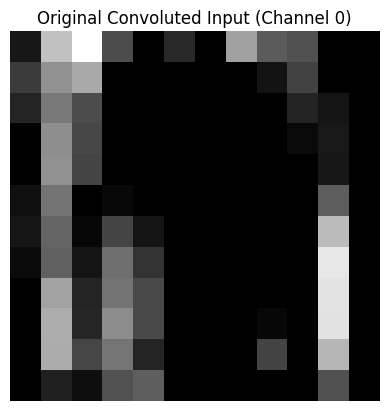

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
import matplotlib.pyplot as plt

# Rebuild only the conv+pool part (no Flatten)
input_img = Input(shape=(28,28,1))
x = Conv2D(32, (5,5), activation='relu')(input_img)
x = MaxPooling2D(pool_size=(2,2))(x)
conv_only_model = Model(inputs=input_img, outputs=x)

# Get feature map
feature_map = conv_only_model.predict(X_test[0:1])  # shape: (1, 12, 12, 32)

# Plot first channel
plt.imshow(feature_map[0, :, :, 0], cmap='gray')
plt.title("Original Convoluted Input (Channel 0)")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


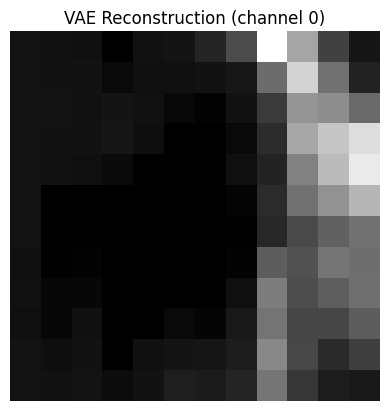

In [16]:
x_sample = X_test[0:1]
flat_input = conv_model.predict(x_sample).reshape(1, -1)
reconstructed = vae.decoder(vae.encoder(flat_input)[2]).numpy().reshape(12, 12, 32)

plt.imshow(reconstructed[:, :, 0], cmap='gray')  # Show just the first channel
plt.axis('off')
plt.title("VAE Reconstruction (channel 0)")
plt.show()


not bad, the reconstruction